# Creating an ADCIRC Dataset

The following notebook demonstrates how to identify and compile storm surge events for ADCIRC hind-casts.

**Clint Dawson, University of Texas at Austin**  
**Carlos del-Castillo-Negrete, University of Texas at Austin**  
**Benjamin Pachev, University of Texas at Austin**  

## Citation and Licensing

* Please cite [Rathje et al. (2017)](https://doi.org/10.1061/(ASCE)NH.1527-6996.0000246) to acknowledge the use of DesignSafe resources.  

* This software is distributed under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html).  

<a id='outline'></a>
## Outline

2. [Backgorund](#background)
3. [Set up](#set_up)
4. [Finding Events](#finding)
5. [Getting Forcing Data](#forcing)

<a id='background'></a>
# Background
[Back to top](#outline)

The following section contains brief explanations and links on the key background topics that it is assumed the reader has some knowledge or familiarity with including:

1. [ADCIRC](#adcirc)
3. [PyADCIRC](#pyADCIRC)

<a id='adcirc'></a>
### ADCIRC
[Back to start of section](#background)

For more information on running ADCIRC and documentation, see the following links:

* [ADCIRC Wiki](https://wiki.adcirc.org/wiki/Main_Page)
* [ADCIRC Web Page](https://adcirc.org/)

ADCIRC is available as a standalone app accesible via the [DesignSafe front-end](https://www.designsafe-ci.org/rw/workspace/#!/ADCIRC::Simulation).

An ADCIRC run is controlled by a variety of input files that can vary depending on the type of simulation being run. They all follow the naming convention fort.# where the # determines the type of input/output file. For a full list of input files for ADCIRC see the [ADCIRC documentation](https://adcirc.org/home/documentation/users-manual-v50/input-file-descriptions/). At a high level the inputs compose of the following:

- Base Mesh input files - Always present for a run. It will be assumed for the purpose of this UseCase that the user starts from a set of mesh input files.
    - fort.14 - ADCIRC mesh file, defining the domain and bathymetry.
    - fort.15 - ADCIRC control file, containing (most) control parameters for the run. This includes:
        - Solver configurations such as time-step, and duration of simuation.
        - Output configurations, including frequency of output, and nodal locations of output.
        - Tidal forcing - At a minimum, ADCIRC is forced using tidal constituents.
    - Additional control files (there are a lot more, just listing the most common here):
        - fort.13 - Nodal attribute file
        - fort.19, 20 - Additional boundary condition files.
- Metereological forcing files - Wind, pressure, ice coverage, and other forcing data for ADCIRC that define a particular storm surge event.
    - fort.22 - Met. forcing control file.
    - fort.221, fort.222, fort.225, fort.22* - Wind, pressure, ice coverage (respective), and other forcing files.
    - 

**The focus of this use case is to compile sets of storm surge events, each comprising different sets of forcing files, for a region of interest defined by a set of mesh control files.**

<a id='pyADCIRC'></a>
### PyADCIRC
[Back to start of section](#background)

[PyADCIRC](https://github.com/UT-CHG/pyadcirc) is a python library of ADCIRC simulation related utilities. 
The following use case will use the following two entrypoints of the library for compiling and ADCIRC hind-cast dataset:

1. [NOAAs tidal gauge data](https://tidesandcurrents.noaa.gov/) - For identifying storm surge. They provide a [public API](https://api.tidesandcurrents.noaa.gov/api/prod/) for accessing their data. The pyADCIRC library provides convenient wrapper around this API, and a CLI for interacting with it (more in the following sections). 

2. [NCAR’s CFSv1/v2 data sets](https://api.tidesandcurrents.noaa.gov/api/prod/) - For retrieving meteorological forcing files for identify storm surge events. An NCAR account is required for accessing this dataset. The pyADCIRC library provides utilities to grab data from their repositories provided a user account is set-up.

<a id='set_up'></a>
# Set Up
[Back to top](#outline)

In the following section we will cover:

1. [Installing and loading libraries](#install)
2. [Utility Functions](#utility)
3. [Notebook Location](#location)
4. [NCAR Account](#ncar)

For starters make sure you change the below to your appropriate user id.

<a id='install'></a>
### Installing and Loading Libraries
[Back to start of section](#set_up)

Note, there is one conda environment package that must be installed to work with the grib files downloaded from NCAR. 
This is the (python-eccodes)[https://anaconda.org/conda-forge/python-eccodes] library.
Make sure to conda install this library in a terminal outside of this notebook (in the same conda environment as the juypter kernel being used) with the following:

```bash
conda install -c conda-forge python-eccodes
```

In [1]:
%pip install pyadcirc

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datetime
import importlib
import json
import os
import pdb

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from alive_progress import alive_bar
from cartopy import crs

import pyadcirc.data.noaa as noaa
import pyadcirc.viz.viz as viz
from pyadcirc.data.ncar import NCARDownloader
from pyadcirc.io import io as pyio

dask.config.set({"array.slicing.split_large_chunks": True})


### Creating Directories

We will need directories to store data and files for this use case.

In [28]:
!mkdir -p data figures

<a id='utility'></a>
### Utility Functions
[Back to start of section](#set_up)

The following section contains utility functions that support the rest of the sections of the notebook. 

In [5]:
# Matplotlib plotting options
plot_params = {
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "axes.labelsize": 20,
    "axes.titlesize": 26,
    "legend.fontsize": 20,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlepad": 1,
    "axes.labelpad": 1,
    "font.size": 20,
    "savefig.facecolor": "white",
    "text.usetex": False,
    "text.latex.preamble": " ".join(
        [r"\usepackage{bm}", r"\usepackage{amsfonts}", r"\usepackage{amsmath}"]
    ),
}
plt.rcParams.update(plot_params)

In [6]:
def plot_event(
    events,
    event_idx=0,
    annotate=True,
    continuity_factor=0.9,
    trigger_threshold=1.0,
    value="Difference",
    dt_col=True,
    ax=None,
    legend=True,
):
    """
    Plot identified storm-surge event.
    """
    event = events.loc[event_idx].copy()

    x_col = "Date Time"
    if not dt_col:
        x_col = "Time Step"
        event[x_col] = np.arange(0, len(event[value].values))

    if ax is None:
        event.plot(
            x=x_col,
            y=value,
            marker="o",
            markersize=1,
            linestyle="-",
            figsize=(16, 8),
            legend=legend,
        )
        ax = plt.gca()
    else:
        event.plot(
            x=x_col,
            y=value,
            marker="o",
            markersize=1,
            linestyle="-",
            ax=ax,
            legend=legend,
        )

    if annotate:
        center = 1.5
        shoulder_period_height = [0.0, 3.0]
        continuity_threshold = continuity_factor * trigger_threshold
        event["C"] = event["Difference"] > continuity_threshold
        shoulder_start = event[event["C"] == True]["Date Time"].min()
        shoulder_end = event[event["C"] == True]["Date Time"].max()
        ax.plot(
            [event["Date Time"].min(), event["Date Time"].max()],
            [trigger_threshold, trigger_threshold],
            label="$T_t = $ Trigger Threshold",
        )
        ax.plot(
            [event["Date Time"].min(), event["Date Time"].max()],
            [continuity_threshold, continuity_threshold],
            label="$T_c = cT_t = $ Continuity Threshold",
        )
        ax.plot(
            [event["Date Time"].min(), shoulder_start],
            [center, center],
            "--k",
            label="Shoulder Periods",
        )
        ax.plot([shoulder_end, event["Date Time"].max()], [center, center], "--k")
        ax.plot(
            [event["Date Time"].min(), event["Date Time"].min()],
            shoulder_period_height,
            "--k",
        )
        ax.plot([shoulder_start, shoulder_start], shoulder_period_height, "--k")
        ax.plot(
            [event["Date Time"].max(), event["Date Time"].max()],
            shoulder_period_height,
            "--k",
        )
        ax.plot([shoulder_end, shoulder_end], shoulder_period_height, "--k")

    if legend:
        ax.legend()
    ax.set_ylabel("$\zeta$ (m)")

    return ax

<a id='location'></a>
### Copying Notebook
[Back to start of section](#set_up)

This notebook assumes you have copied the ADCIRC Use Case folder (and all its contents) to your MyData folder. This is necessary as the CommunityData folder that contains the original copy of this notebook is read-only. If you copy your my data to some other location, please specify the location below.

In [7]:
uid = os.environ["JUPYTERHUB_USER"]
notebook_path = f"{uid}/ADCIRC-UseCase"
notebook_uri = input_uri = f"agave://designsafe.storage.default/{notebook_path}"

KeyError: 'JUPYTERHUB_USER'

<a id='ncar'></a>
### NCAR Account Set-UP
[Back to start of section](#set_up)

Make sure to go to NCAR's website to request an account for their data.
You'll need your login information for pulling data from their repositories.
Once your account is set-up, you'll want to store your credentials in a json file in the same directory as this noteboo, with the name `.ncar.json`.
For example the file may look like:

```json
{'email': "user@gmail.com", 'pw': '12345'}
```

To check if your library is set-up appropriately, 

<a id='finding'></a>
# Finding Storm Surge Events
[Back to top](#outline)

In the following section we will use the pyADCIRC library's wrapper around NOAA's tide and gauge API to find storm surge events in a region of interest. 

We will focus on Alaska as a region of interest, but note that many regions exist. 

## Getting list of stations

A list of stations can be obtained by accessomg the `NOAA_STATIONS` variable within the `noaa` module of the `pyADCIRC` library.

In [8]:
noaa.NOAA_STATIONS

,Region,ID,Name
0,Alabama,8732828,"Weeks Bay, Mobile Bay"
1,Alabama,8735180,"Dauphin Island, AL"
2,Alabama,8735391,"Dog River Bridge, AL"
3,Alabama,8735523,"East Fowl River Bridge, AL"
4,Alabama,8736897,"Coast Guard Sector Mobile, AL"
...,...,...,...
289,Washington,9445958,"Bremerton, WA"
290,Washington,9446484,"Tacoma, WA"
291,Washington,9447130,"Seattle, WA"
292,Washington,9449424,"Cherry Point, WA"


We can filter the list of stations by a region of interest. For example, we can filter to find stations in the region of Alaska.

In [9]:
ak_stations = noaa.NOAA_STATIONS[noaa.NOAA_STATIONS["Region"] == "Alaska"]

## Getting station metadata

The `get_station_metadata` function allows us to view more info on a station including a link to the front end website.

In [10]:
# pandas dataframe - index using iloc if not searching on index key
first_station = ak_stations.iloc[0]
noaa.get_station_metadata(int(first_station["ID"]))

{'name': 'Ketchikan',
 'id': 9450460,
 'coords': [228.373889, 55.331944],
 'link': 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460'}

## Command Line Interface (CLI)

Note the command line interface can also be used to get the data (which can be done in a terminal outside of a notebook wherever pyADCIRC is installed).

Use `noaa_data --help` for more info on the avialable CLI commands

In [9]:
!noaa_data --help

    _   ______  ___    ___       ___    ____  ____
   / | / / __ \/   |  /   |     /   |  / __ \/  _/
  /  |/ / / / / /| | / /| |    / /| | / /_/ // /  
 / /|  / /_/ / ___ |/ ___ |   / ___ |/ ____// /   
/_/ |_/\____/_/  |_/_/  |_|  /_/  |_/_/   /___/   
                                                  

Python wrapper around: https://api.tidesandcurrents.noaa.gov/api/prod/


                                                                                
 Usage: noaa_data [OPTIONS] COMMAND [ARGS]...                                   
                                                                                
 Commands for interacting with the NOAA API                                     
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --help      Show this message and exit.                                      │
╰────────────────────────────────────────────────────

The help function can be used for sub-commands as well. For example, `noaa_data get --help` will provide more info on the `get` sub-command.

In [11]:

!noaa_data get --help

    _   ______  ___    ___       ___    ____  ____
   / | / / __ \/   |  /   |     /   |  / __ \/  _/
  /  |/ / / / / /| | / /| |    / /| | / /_/ // /  
 / /|  / /_/ / ___ |/ ___ |   / ___ |/ ____// /   
/_/ |_/\____/_/  |_/_/  |_|  /_/  |_/_/   /___/   
                                                  

Python wrapper around: https://api.tidesandcurrents.noaa.gov/api/prod/


                                                                                
 Usage: noaa_data get [OPTIONS] STATION_ID                                      
                                                                                
 Get a product over a date range at particular station:                         
 noaa_data get -p water_level                                                   
 For list of available stations see:                                            
                                                                                
╭─ Options ──────────────────────────────────────────

As we can see there are a variety of different products and output formats avaible.
To get station metadata as before, we can use the following call with the CLI.

In [10]:
!noaa_data get -p metadata 9450460

    _   ______  ___    ___       ___    ____  ____
   / | / / __ \/   |  /   |     /   |  / __ \/  _/
  /  |/ / / / / /| | / /| |    / /| | / /_/ // /  
 / /|  / /_/ / ___ |/ ___ |   / ___ |/ ____// /   
/_/ |_/\____/_/  |_/_/  |_|  /_/  |_/_/   /___/   
                                                  

Python wrapper around: https://api.tidesandcurrents.noaa.gov/api/prod/


id,name,link,Longitude,Latitude
9450460,Ketchikan,https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460,228.373889,55.331944


## Station URL

We can explore the station at the following link:

https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460

In [11]:
station_link = f"https://tidesandcurrents.noaa.gov/stationhome.html?id={9450460}"
station_link

'https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460'

## Identifying Events - Example: Merbok at Nome, AK

Let's see how this algorithm performs for identifiynhg 

### Wicks Algorithm Breakdown

To identify storm-surge events, we use the `get_event_dataset` entrypoint.
This function implements an algorithm first proposed by [ref], and used more recently in [ref].

A rough breakdown of the algorithm is as follow:

1. True false flag if residual level above trigger threshold (T).
2. Create groups between each switch between over/under threshold
3. Each under-threshold group Group is joined with surrounding groups if:

    a. **Lull period (L)** - If duration of group less than "lull" duration L. Default = 6h = 21600s.
    
    b. **Continuation threshold (C)** - If values in the group do not drop below secondary "continuity" threshold C, usually specified as a ratio of the target threshold. Default = 0.9T.
    
   Else the grouping is considered to be a separator between distinct events.
   
4. For each found grouping:

    a. **Shoulder Rule (S)** - include time periods before and after event - Include data S hours before and after identified event (measured by crossing of continuity threshold). Default = 12h = 43200s
    
    b. **Chute Rule (R)** - Include water levels that are below thresholds but considered part of onset and return of surge event -> So include R steps before and after storm surge event (after dropping below continuity threshold). Default = 9

In [12]:
nome = 9468756
noaa.get_station_metadata(nome)

{'name': 'Nome, Norton Sound',
 'id': 9468756,
 'coords': [194.560361, 64.494611],
 'link': 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9468756'}

In [13]:
trigger_thresold = 1.0
continuity_thresold = 0.9
lull_duration = 21600
shoulder_period = 43200
chute_rule = 9

In [14]:
begin_date = "2022-08-01 00:00:00"
end_date = "2022-11-01 00:00:00"
merbok = noaa.get_event_dataset(
    nome, trigger_threshold=1.0, begin_date=begin_date, end_date=end_date
)

In [15]:
merbok

,Type,Date Time,Prediction,Water Level,Sigma,Difference,Duration (Hours)
Event ID,,,,,,,
0,Positive,2022-09-16 06:30:00,0.0540000000,0.4710000000,0.0150000000,0.4170000000,"2,208.0000000000"
0,Positive,2022-09-16 06:36:00,0.0600000000,0.4830000000,0.0090000000,0.4230000000,"2,208.0000000000"
0,Positive,2022-09-16 06:42:00,0.0660000000,0.4950000000,0.0110000000,0.4290000000,"2,208.0000000000"
0,Positive,2022-09-16 06:48:00,0.0720000000,0.5290000000,0.0110000000,0.4570000000,"2,208.0000000000"
0,Positive,2022-09-16 06:54:00,0.0770000000,0.5200000000,0.0160000000,0.4430000000,"2,208.0000000000"
...,...,...,...,...,...,...,...
1,Negative,2022-10-27 04:06:00,-0.0180000000,-0.6070000000,0.0040000000,0.5890000000,"2,208.0000000000"
1,Negative,2022-10-27 04:12:00,-0.0150000000,-0.6010000000,0.0050000000,0.5860000000,"2,208.0000000000"
1,Negative,2022-10-27 04:18:00,-0.0110000000,-0.6030000000,0.0040000000,0.5920000000,"2,208.0000000000"


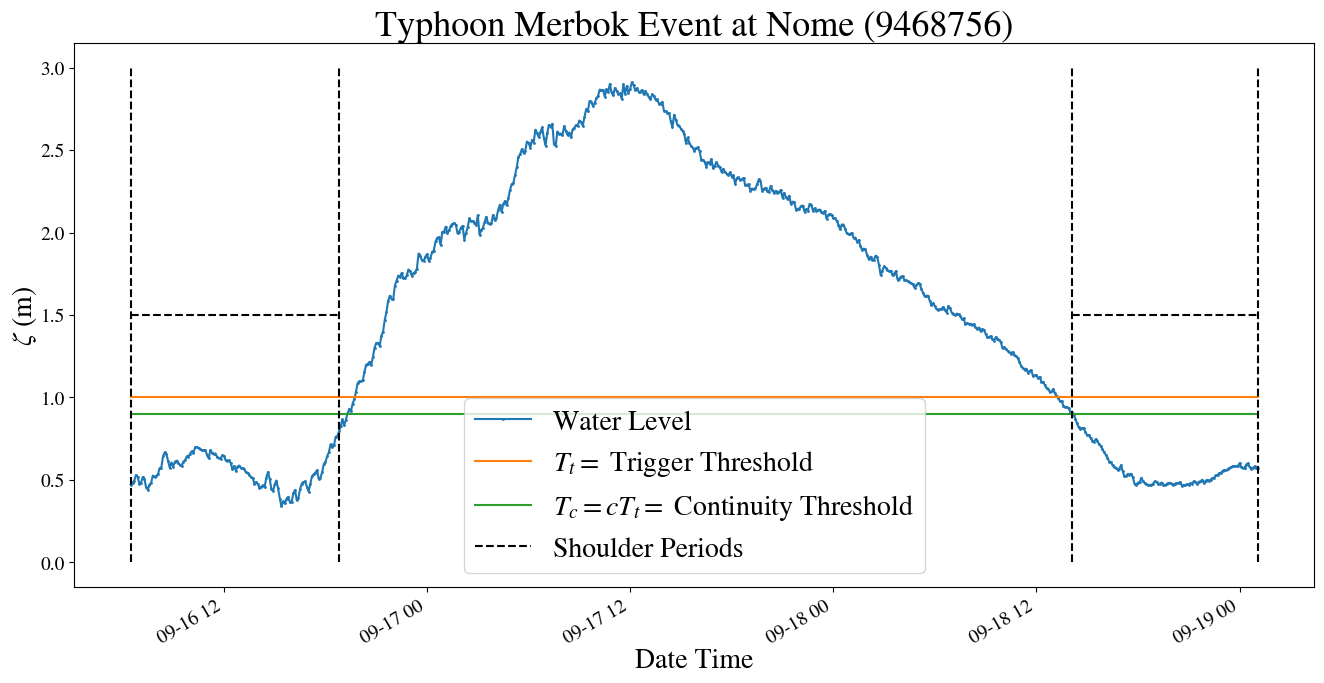

In [16]:
ax = plot_event(merbok, event_idx=0, value="Water Level")
ax.set_title(f"Typhoon Merbok Event at Nome ({nome})")

plt.savefig("merbook_event_nome.png", dpi=400)

## Compiling DataSet of Events

There are three main stations along the Western coast of Alaska that we will focus on: 

1. Nome
2. Red Dog Dock
3. Unalakleet

Let's compile a set of all events for all data available from each station.
This will involve:

1. Applying the identification algorithm at each station.
2. Merging overlapping events accross stations.
3. Removing negative surge events (only focus on positive surge events).

From this list of dates for surge events, will will grab meteorological forcing for ADCIRC hindcasts.

### 9468756	Nome , AK

Lets get the station meta-data for Nome, AK.
We can go the link provided in the return to see from what start date data is available.
In particular we go to the link to see that the station has been in operation since July of 1992.
Using this information, we can use the `get_event_dataset` function to get a list of events for Nome, AK.
This will apply an identification algorithm over the date range to try and identify distinct storm surge events.


In [29]:
nome = 9468756
noaa.get_station_metadata(nome)

{'name': 'Nome, Norton Sound',
 'id': 9468756,
 'coords': [194.560361, 64.494611],
 'link': 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9468756'}

In [24]:
nome_begin_date = pd.to_datetime("19920101 00:00")
nome_end_date = pd.to_datetime("20230101 00:01")
nome_events = noaa.get_event_dataset(
    nome, begin_date=nome_begin_date, end_date=nome_end_date
)
nome_events.to_csv("data/nome_1m.csv", index=True, header=True)

In [25]:
nome_events

,Type,Date Time,Prediction,Water Level,Sigma,Difference,Duration (Hours)
Event ID,,,,,,,
0,Positive,1993-01-07 01:36:00,0.1750000000,0.6780000000,NaN,0.5030000000,"2,243.0000000000"
0,Positive,1993-01-07 01:42:00,0.1750000000,0.6870000000,NaN,0.5120000000,"2,243.0000000000"
0,Positive,1993-01-07 01:48:00,0.1740000000,0.6930000000,NaN,0.5190000000,"2,243.0000000000"
0,Positive,1993-01-07 01:54:00,0.1730000000,0.7050000000,NaN,0.5320000000,"2,243.0000000000"
0,Positive,1993-01-07 02:00:00,0.1720000000,0.7230000000,NaN,0.5510000000,"2,243.0000000000"
...,...,...,...,...,...,...,...
167,Negative,2022-12-26 20:18:00,0.1830000000,0.0010000000,0.0020000000,0.1820000000,"7,053.1000000000"
167,Negative,2022-12-26 20:24:00,0.1820000000,-0.0020000000,0.0020000000,0.1840000000,"7,053.1000000000"
167,Negative,2022-12-26 20:30:00,0.1810000000,-0.0020000000,0.0020000000,0.1830000000,"7,053.1000000000"


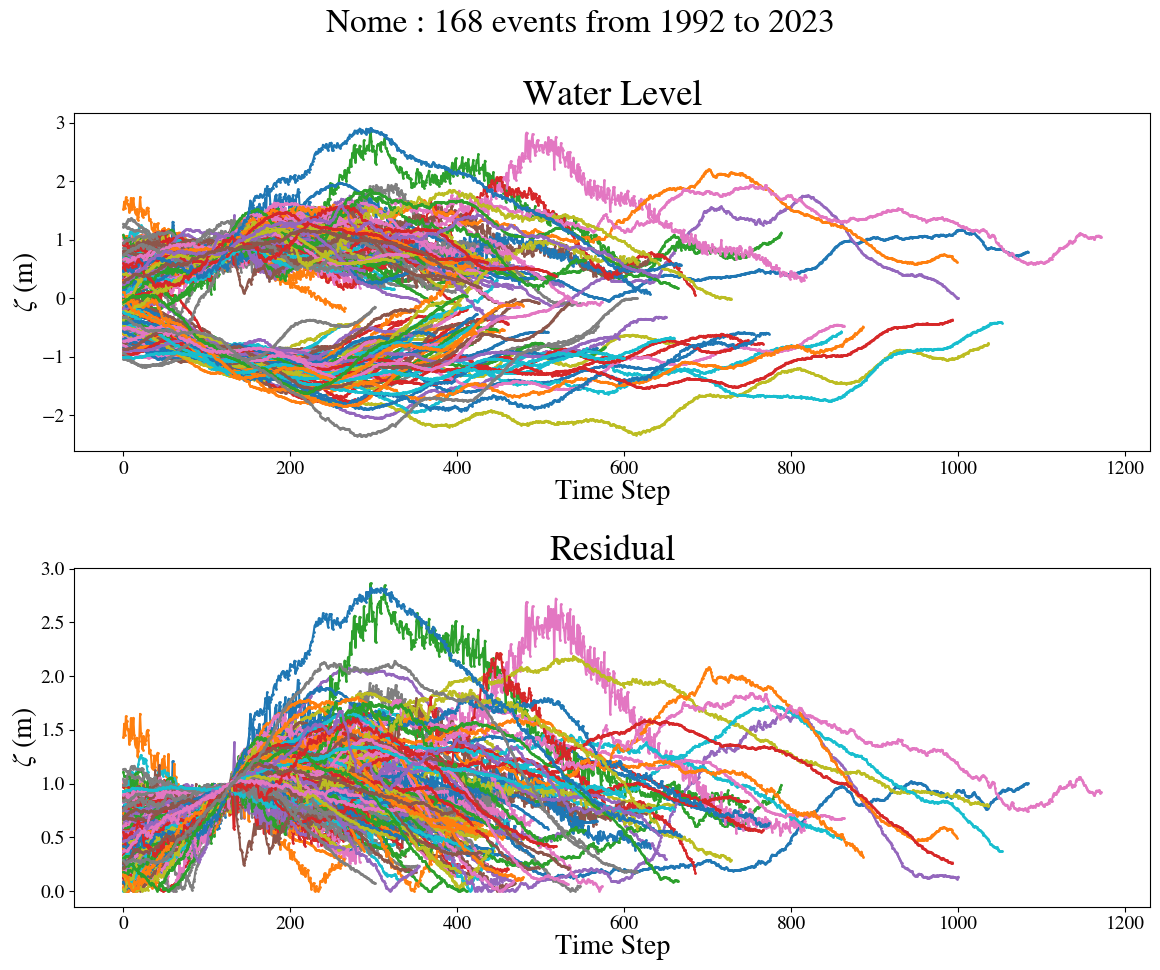

In [27]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for name, e in nome_events.groupby("Event ID"):
    plot_event(
        nome_events,
        name,
        value="Water Level",
        ax=ax1,
        annotate=False,
        legend=False,
        dt_col=False,
    )
    plot_event(
        nome_events,
        name,
        value="Difference",
        ax=ax2,
        annotate=False,
        legend=False,
        dt_col=False,
    )

ax1.set_title(f"Water Level")
ax2.set_title(f"Residual")

plt.suptitle(
    f"Nome : {len(np.unique(nome_events.index))} events from {nome_begin_date.year} to {nome_end_date.year}"
)

fig.tight_layout()

plt.savefig("figures/nome_1m_all.png")

### 9491094	Red Dog Dock, AK

For Red Dog Dock, we see the NOAA tide station has been in operation since August of 2003.

In [31]:
rdd = 9491094
noaa.get_station_metadata(rdd)

{'name': 'Red Dog Dock',
 'id': 9491094,
 'coords': [195.935611, 67.575806],
 'link': 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9491094'}

In [33]:
rdd_begin_date = pd.to_datetime("20030101 00:00")
rdd_end_date = pd.to_datetime("20230101 00:01")
rdd_events = noaa.get_event_dataset(
    rdd, begin_date=rdd_begin_date, end_date=rdd_end_date
)
rdd_events.to_csv(f"data/rdd_1m.csv", index=True, header=True)

In [ ]:
rdd_events

,Type,Date Time,Prediction,Water Level,Sigma,Difference,Duration (Hours)
Event ID,,,,,,,
0,Positive,2004-10-18 21:42:00,-0.0670000000,-0.2750000000,0.1510000000,0.2080000000,"4,485.0000000000"
0,Positive,2004-10-18 21:48:00,-0.0670000000,-0.3160000000,0.1990000000,0.2490000000,"4,485.0000000000"
0,Positive,2004-10-18 21:54:00,-0.0680000000,-0.3410000000,0.1840000000,0.2730000000,"4,485.0000000000"
0,Positive,2004-10-18 22:00:00,-0.0690000000,-0.3260000000,0.1460000000,0.2570000000,"4,485.0000000000"
0,Positive,2004-10-18 22:06:00,-0.0690000000,-0.3190000000,0.1370000000,0.2500000000,"4,485.0000000000"
...,...,...,...,...,...,...,...
42,Positive,2022-10-08 02:06:00,0.1110000000,0.6350000000,0.0730000000,0.5240000000,"6,214.0000000000"
42,Positive,2022-10-08 02:12:00,0.1070000000,0.6320000000,0.0830000000,0.5250000000,"6,214.0000000000"
42,Positive,2022-10-08 02:18:00,0.1030000000,0.6250000000,0.0960000000,0.5220000000,"6,214.0000000000"


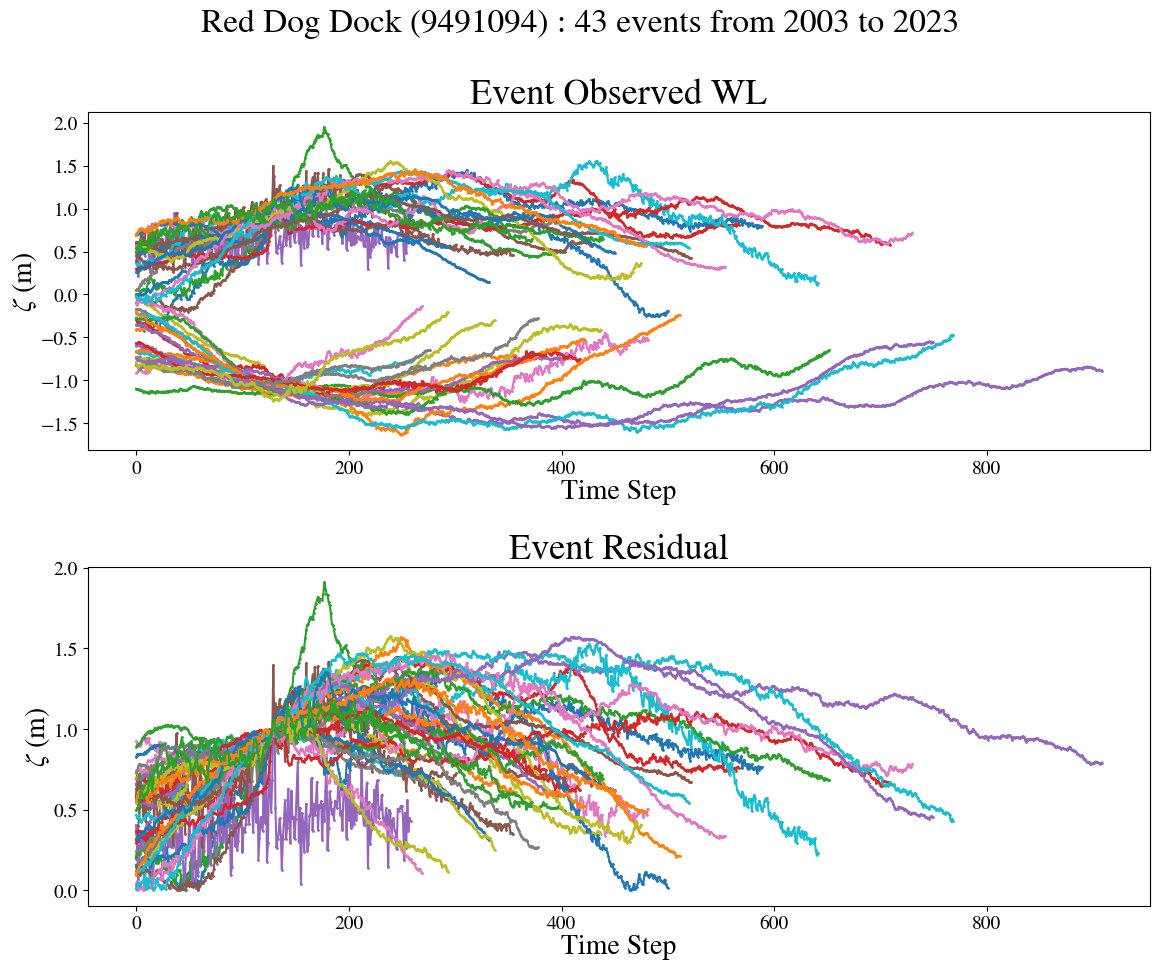

In [29]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for name, e in rdd_events.groupby("Event ID"):
    plot_event(
        rdd_events,
        name,
        value="Water Level",
        ax=ax1,
        annotate=False,
        legend=False,
        dt_col=False,
    )
    plot_event(
        rdd_events,
        name,
        value="Difference",
        ax=ax2,
        annotate=False,
        legend=False,
        dt_col=False,
    )

ax1.set_title(f"Event Observed WL")
ax2.set_title(f"Event Residual")

plt.suptitle(
    f"Red Dog Dock ({rdd}) : {len(np.unique(rdd_events.index))} events from {rdd_begin_date.year} to {rdd_end_date.year}"
)

fig.tight_layout()

plt.savefig("rdd_1m_all.png")

### 9468333 Unalakleet, AK

Lets see thet station metadata - In particular we go to the link to see that the station has been in operation since May 01, 2011

In [32]:
una = 9468333
noaa.get_station_metadata(una)

{'name': 'Unalakleet',
 'id': 9468333,
 'coords': [199.2157, 63.871361],
 'link': 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9468333'}

In [34]:
una_begin_date = pd.to_datetime("20110501 00:00")
una_end_date = pd.to_datetime("20230101 00:01")
una_events = noaa.get_event_dataset(
    una, begin_date=una_begin_date, end_date=una_end_date
)
una_events.to_csv(f"data/unalakleet_1m.csv", index=True, header=True)

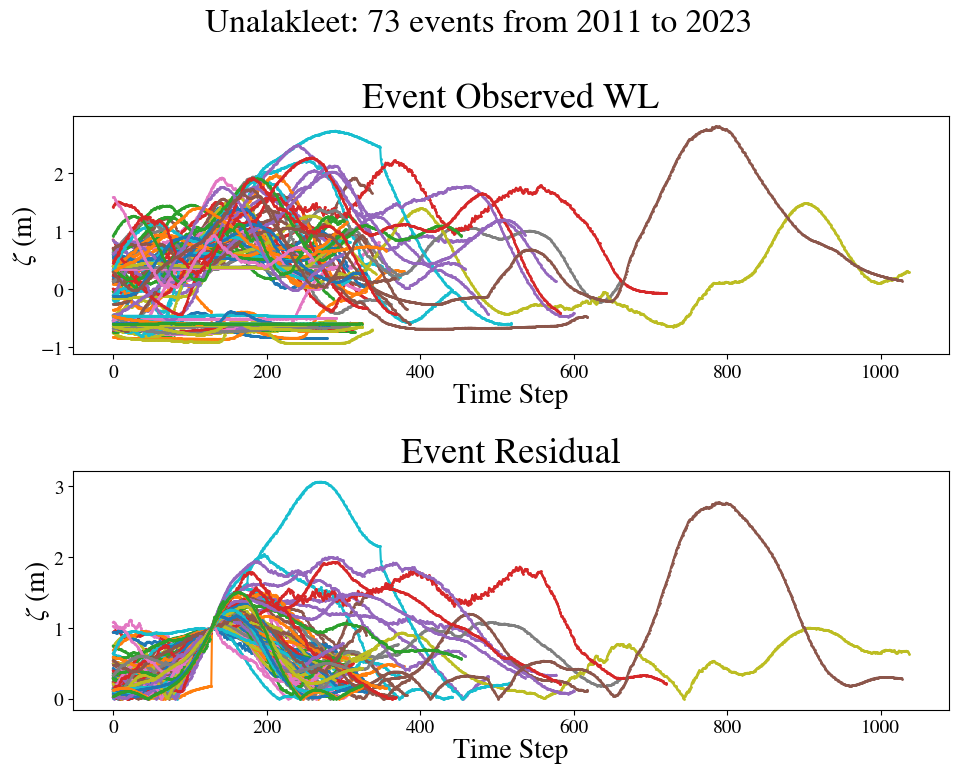

In [35]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for name, e in una_events.groupby("Event ID"):
    plot_event(
        una_events,
        name,
        value="Water Level",
        ax=ax1,
        annotate=False,
        legend=False,
        dt_col=False,
    )
    plot_event(
        una_events,
        name,
        value="Difference",
        ax=ax2,
        annotate=False,
        legend=False,
        dt_col=False,
    )

ax1.set_title(f"Event Observed WL")
ax2.set_title(f"Event Residual")

plt.suptitle(
    f"Unalakleet: {len(np.unique(una_events.index))} events from {una_begin_date.year} to {una_end_date.year}"
)

fig.tight_layout()

### Consolodating Events from Different Locations

Lets consolidate events across locations, into a set of non-overlapping events.
For now we will also filter out negeative surge events and only focus on positive storm surge.

In [43]:
dfs = {}
for n in ["nome", "unalakleet", "rdd"]:
    dfs[n] = pd.read_csv(f"data/{n}_1m.csv")
    
events = []
for station, df in dfs.items():
    df = df[df["Type"] == "Positive"]
    gb = df.groupby("Event ID")
    starts = gb["Date Time"].first()
    ends = gb["Date Time"].last()
    events += list(zip(starts, ends))
events = sorted(events)

# consolidate events that overlap
all_events = [events[0]]
for event in events[1:]:
    last_event = all_events[-1]
    # overlapping - replace
    if event[0] < last_event[1]:
        new_end = max(event[1], last_event[1])
        all_events[-1] = (last_event[0], new_end)
    else:
        all_events.append(event)
print(
    f"{len(all_events)} Events.\nFirst: {all_events[0]}\nLast: {all_events[-1]}"
)
with open("data/alaska_1m_events.json", "w") as fp:
    json.dump(all_events, fp)

120 Events.
First: ('1993-01-07 01:36:00', '1993-01-13 18:18:00')
Last: ('2022-12-09 21:06:00', '2022-12-11 12:12:00')


# Getting Forcing Data for Events

## Example - First Event

In [42]:
start_date = all_events[0][0]
end_date = all_events[0][1]

In [44]:
downloader = NCARDownloader()
fnames = downloader.download(
    dataset="ds093.1",
    variables=["prmsl", "wnd10m", "icecon"],
    start_date=start_date,
    end_date=end_date,
)

['https://rda.ucar.edu/data//ds093.1/1993/prmsl.gdas.199301.grb2']
['https://rda.ucar.edu/data//ds093.1/1993/wnd10m.gdas.199301.grb2']
['https://rda.ucar.edu/data//ds093.1/1993/icecon.gdas.199301.grb2']
100.000 % Completed
100.000 % Completed
100.000 % Completed


In [2]:
start_date = '1993-01-07 01:36:00'
end_date = '1993-01-13 18:18:00'
fnames = {'prmsl': 'prmsl.gdas.199301.grb2',
          'wnd10m': 'wnd10m.gdas.199301.grb2',
          'icecon': 'icecon.gdas.199301.grb2'}

### Pressure Data

In [2]:
press_data = pyio.cfsv2_grib_to_adcirc_netcdf(
    fnames['prmsl'],
    date_range=[start_date, end_date],
    bounding_box=[140, 240, 80, 40],
    output_name='data/fort.221.nc',
)
press_data

NameError: name 'fnames' is not defined

In [89]:
press_data = xr.open_dataset('data/fort.221.nc')
press_data

<xarray.Dataset>
Dimensions:    (time: 27, latitude: 81, longitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-07T06:00:00 ... 1993-01-13T18:00:00
  * latitude   (latitude) float64 80.0 79.5 79.0 78.5 ... 41.5 41.0 40.5 40.0
  * longitude  (longitude) float64 140.0 140.5 141.0 141.5 ... 239.0 239.5 240.0
Data variables:
    prmsl      (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-16T22:21 GRIB to CDM+CF via cfgrib-0.9.1...

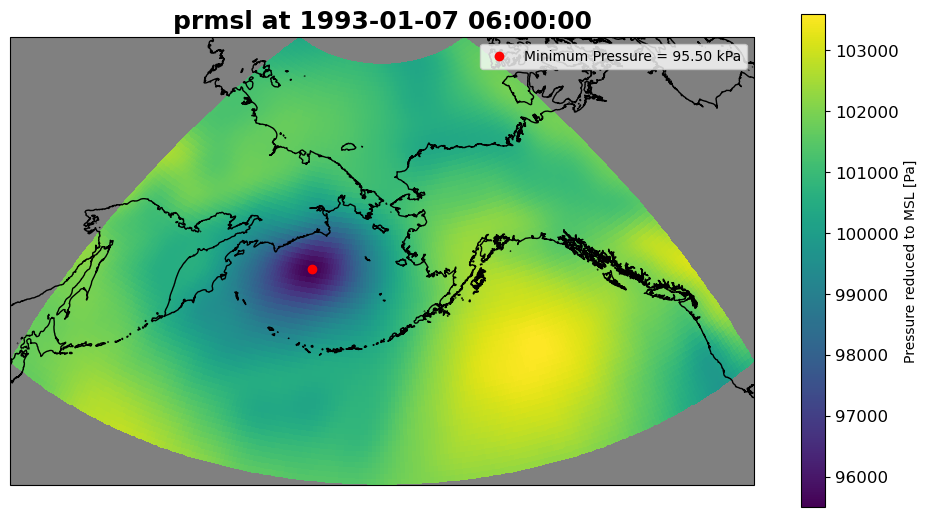

In [99]:
plt.figure(figsize=(12, 8))

ax = viz.pyplot_mesh(
    press_data,
    "prmsl",
    projection=crs.Orthographic(-170, 45),
    timestep=0,
    features=[("coastlines", {"resolution": "10m", "color": "black"})],
)
# Add (x, y) points at each time_step for min_x and min_y
min_press = press_data['prmsl'].isel(time=0).argmin(dim=['latitude', 'longitude'])
mp_0 = press_data['prmsl'].isel(time=0).isel(longitude=min_press['longitude'], latitude=min_press['latitude'])

ax.scatter(x=press_data['longitude'][min_press['longitude']],
              y=press_data['latitude'][min_press['latitude']],
              transform=crs.PlateCarree(),
              color='red',
              label='Minimum Pressure = {:0.2f} kPa'.format(mp_0.values / 1000.0))
ax.legend()

### Wind Magnitued and Direction

In [3]:
wind_data = pyio.cfsv2_grib_to_adcirc_netcdf(
    fnames['wnd10m'],
    date_range=[start_date, end_date],
    bounding_box=[140, 240, 80, 40],
    output_name='data/fort.222.nc',
)
wind_data

Writing to data/fort.222.nc:
[########################################] | 100% Completed | 105.43 ms


<xarray.Dataset>
Dimensions:    (time: 27, latitude: 128, longitude: 320)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-07T06:00:00 ... 1993-01-13T18:00:00
  * latitude   (latitude) float64 79.77 79.46 79.15 78.84 ... 40.75 40.43 40.12
  * longitude  (longitude) float64 140.3 140.6 140.9 141.2 ... 239.4 239.7 240.0
Data variables:
    u10        (time, latitude, longitude) float32 1.83 1.88 ... -1.41 -3.34
    v10        (time, latitude, longitude) float32 5.28 5.24 5.2 ... 4.24 2.97
    speed      (time, latitude, longitude) float32 5.588 5.567 ... 4.468 4.47
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-16T22:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
wind_data = xr.open_dataset('data/fort.222.nc')
wind_data['speed'] = np.sqrt(wind_data['u10']**2 + wind_data['v10']**2)
wind_data


<xarray.Dataset>
Dimensions:    (time: 27, latitude: 128, longitude: 320)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-07T06:00:00 ... 1993-01-13T18:00:00
  * latitude   (latitude) float64 79.77 79.46 79.15 78.84 ... 40.75 40.43 40.12
  * longitude  (longitude) float64 140.3 140.6 140.9 141.2 ... 239.4 239.7 240.0
Data variables:
    u10        (time, latitude, longitude) float32 1.83 1.88 ... -1.41 -3.34
    v10        (time, latitude, longitude) float32 5.28 5.24 5.2 ... 4.24 2.97
    speed      (time, latitude, longitude) float32 5.588 5.567 ... 4.468 4.47
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-16T23:15 GRIB to CDM+CF via cfgrib-0.9.1...

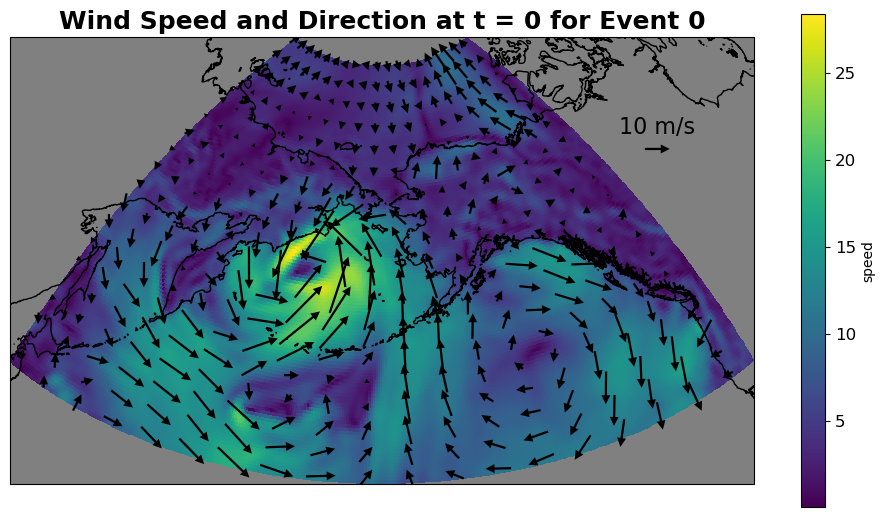

In [6]:
plt.figure(figsize=(12, 8))
res = viz.pyplot_mesh(
    wind_data,
    "speed",
    projection=crs.Orthographic(-170, 45),
    timestep=0,
    features=[("coastlines", {"resolution": "10m", "color": "black"})],
    vec_data=wind_data,
    num_vecs=20,
    save_path="test.png",
    quiver_key_args={
    'X': 0.87, 'Y': 0.75, 'U': 10,
    'label': '10 m/s',
    'labelpos': 'N',
    'fontproperties': {'size': 16},
    },
    title = 'Wind Speed and Direction at t = 0 for Event 0' 
    )

### Sea Ice Concentration


In [100]:
ice_data = pyio.cfsv2_grib_to_adcirc_netcdf(
    fnames['icecon'],
    date_range=[start_date, end_date],
    bounding_box=[140, 240, 80, 40],
    output_name='data/fort.225.nc',
)
ice_data

NameError: name 'fnames' is not defined

In [13]:
ice_data = xr.open_dataset('data/fort.225.nc')
ice_data['std_dev'] = np.std(ice_data['siconc'], axis=0)
ice_data


<xarray.Dataset>
Dimensions:    (time: 27, latitude: 128, longitude: 320)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-07T06:00:00 ... 1993-01-13T18:00:00
  * latitude   (latitude) float64 79.77 79.46 79.15 78.84 ... 40.75 40.43 40.12
  * longitude  (longitude) float64 140.3 140.6 140.9 141.2 ... 239.4 239.7 240.0
Data variables:
    siconc     (time, latitude, longitude) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0
    std_dev    (latitude, longitude) float32 0.0003552 0.0003552 0.0 ... 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-05-16T22:12 GRIB to CDM+CF via cfgrib-0.9.1...

<GeoAxes: title={'center': 'siconc at 1993-01-07 06:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

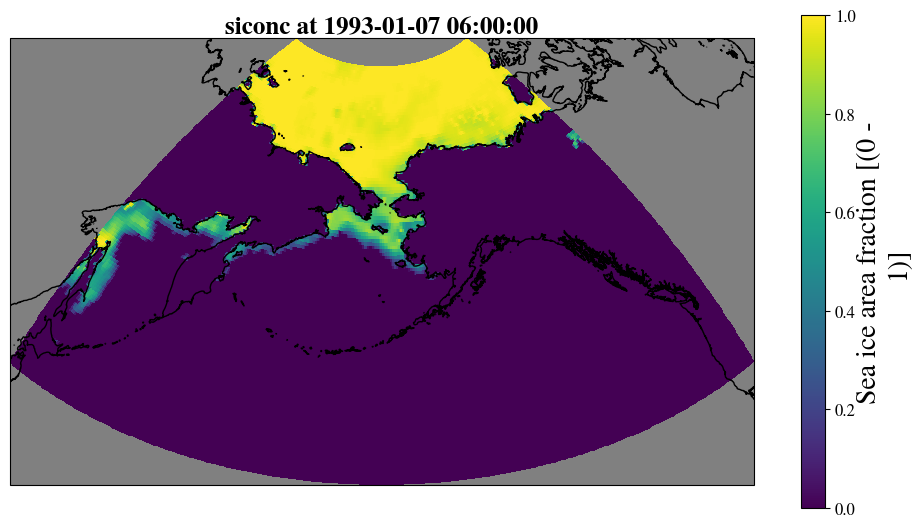

In [14]:
plt.figure(figsize=(12, 8))
viz.pyplot_mesh(
    ice_data,
    "siconc",
    projection=crs.Orthographic(-170, 45),
    timestep=0,
    features=[("coastlines", {"resolution": "10m", "color": "black"})],
)

<GeoAxes: title={'center': 'Standard Deviation of Sea Ice Concentration'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

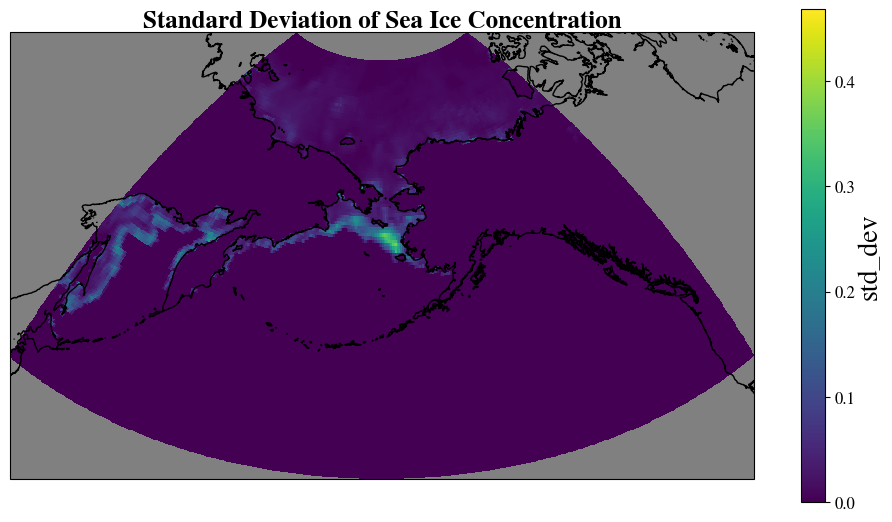

In [15]:
plt.figure(figsize=(12, 8))
viz.pyplot_mesh(
    ice_data,
    "std_dev",
    projection=crs.Orthographic(-170, 45),
    timestep=None,
    features=[("coastlines", {"resolution": "10m", "color": "black"})],
    title='Standard Deviation of Sea Ice Concentration',
)